## Checkpoint 10 - Week 6

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict

DIR = os.getcwd()

2024-03-01 10:05:19.447210: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Exercise 1

In [2]:
data = pd.read_csv(os.path.join(DIR, 'mc-chic1.csv'))

In [3]:
data

,Unnamed: 0,ep,eta,p,phi,pol,pt,qp,tx,ty,zV
0,0,0.005459,3.210803,72.079880,0.294754,1.0,5.803692,72.079880,0.077296,0.023467,-60.3975
1,1,0.004050,4.436362,37.638340,-0.088796,1.0,0.891071,-37.638340,0.023588,-0.002100,-60.3975
2,2,0.003901,3.577396,18.565832,0.319936,1.0,1.036960,18.565832,0.053102,0.017594,-60.3975
3,3,0.003859,3.532860,8.632520,0.219504,1.0,0.504075,-8.632520,0.057089,0.012736,-60.3975
4,4,0.004975,3.300828,43.359665,-0.720869,1.0,3.191501,43.359665,0.055445,-0.048714,-8.0373
...,...,...,...,...,...,...,...,...,...,...,...
208979,208979,0.007196,4.140301,7.805385,0.284841,-1.0,0.248430,-7.805385,0.030561,0.008948,-10.3122
208980,208980,0.007210,3.852298,160.216980,2.341455,-1.0,6.800037,160.216980,-0.029593,0.030478,-47.0282
208981,208981,0.004592,4.234431,32.691210,1.112678,-1.0,0.947065,-32.691210,0.012818,0.025994,-47.0282
208982,208982,0.003816,4.122482,14.349394,2.564155,-1.0,0.464920,14.349394,-0.027161,0.017696,-47.0282


In [4]:
# Are there are any null values?
data.isnull().values.any()

False

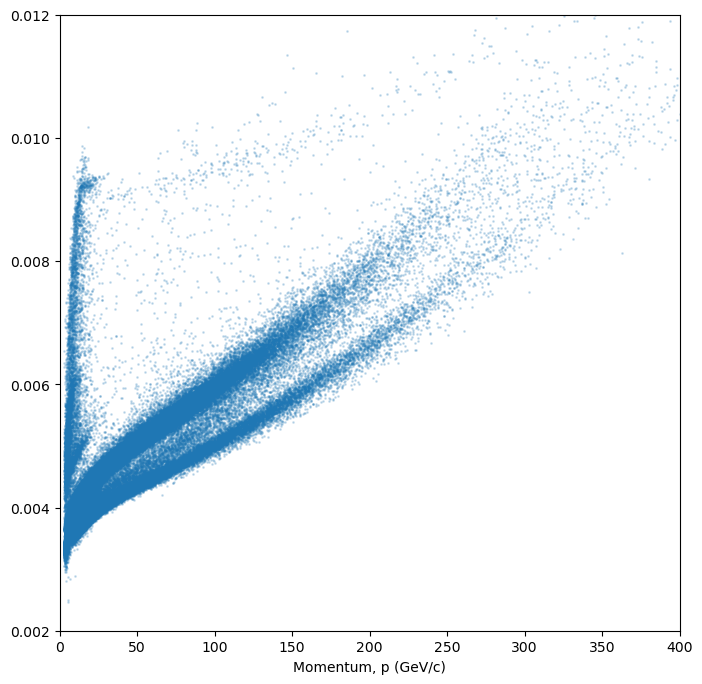

In [5]:
plt.figure(dpi=100, figsize=(8, 8))
plt.scatter(data['p'], data['ep'], s=1, alpha=0.2)
plt.xlabel('Momentum, p (GeV/c)')
plt.xlim(0, 400)
plt.ylim(0.002, 0.012)
plt.show()

### Exercise 2

Distribution for p

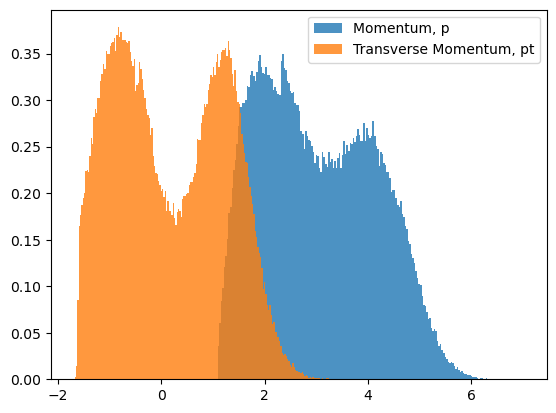

In [6]:
plt.hist(np.log(data['p']), bins=200, density=True, label='Momentum, p', alpha=0.8)
plt.hist(np.log(data['pt']), bins=200, density=True, label='Transverse Momentum, pt', alpha=0.8)
plt.legend()
plt.show()

In [7]:
# pandas.DataFrame.append is deprecated and I can't use it

In [8]:
data['pz'] = np.sqrt(np.square(data['p'])-np.square(data['pt']))
data['epz'] = data['ep']*data['p']/data['pz']

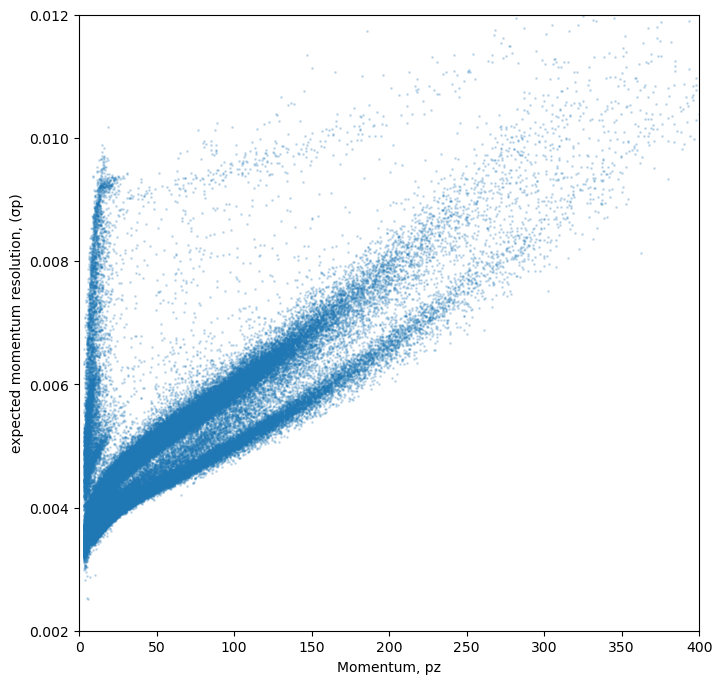

In [9]:
plt.figure(dpi=100, figsize=(8, 8))
plt.scatter(data['pz'], data['epz'], s=1, alpha=0.2)
plt.xlabel('Momentum, pz')
plt.ylabel('expected momentum resolution, (σp)')
plt.xlim(0, 400)
plt.ylim(0.002, 0.012)
plt.show()

The graphs are the same because from the histogram plot we can say that the Transverse Momentum is smaller than the momentum and therefore, the figure above and the orginal figure are the same.

#### Create the Model

In [10]:
# num of inputs = 5 (p, tx, ty, eta, phi), num of outputs = 1 (ep)
num_inputs = 5
num_outputs = 1

# simple Keras model: use same # of nodes as # of inputs, single layer
num_nodes = num_inputs

def simple_model():
    # create model
    model = Sequential()
    
    # Activation is not required for the output, as this is a regression problem,
    # ie. we need a numerical prediction for any input
    model.add(Dense(num_nodes, input_dim=num_inputs, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_outputs, kernel_initializer='normal'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [11]:
N_epochs = 100
batchSize = 1000

dataTable = np.array((data['p'], data['tx'], data['ty'], data['eta'], data['phi'])).T
target = np.array(data['ep']).T

In [12]:
# Sanity check #
dataTable, target

(array([[ 7.2079880e+01,  7.7296040e-02,  2.3466910e-02,  3.2108030e+00,
          2.9475427e-01],
        [ 3.7638340e+01,  2.3587886e-02, -2.1000437e-03,  4.4363620e+00,
         -8.8796474e-02],
        [ 1.8565832e+01,  5.3101793e-02,  1.7593604e-02,  3.5773960e+00,
          3.1993607e-01],
        ...,
        [ 3.2691210e+01,  1.2817692e-02,  2.5993735e-02,  4.2344310e+00,
          1.1126783e+00],
        [ 1.4349394e+01, -2.7161052e-02,  1.7695753e-02,  4.1224820e+00,
          2.5641553e+00],
        [ 1.2054873e+01, -2.8426444e-02,  1.5061451e-02,  4.1301260e+00,
          2.6543593e+00]]),
 array([0.00545875, 0.00405042, 0.00390143, ..., 0.00459183, 0.00381623,
        0.00413777]))

In [13]:
# must always set the random seed for reproducibility
Answer_to_all_questions = 42
np.random.seed(Answer_to_all_questions)

estimator = KerasRegressor(build_fn=simple_model, epochs=N_epochs, batch_size=batchSize, verbose=1)
kfold = KFold(n_splits=10, random_state=Answer_to_all_questions, shuffle=True)

/tmp/ipykernel_1140970/3539739.py:5: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=simple_model, epochs=N_epochs, batch_size=batchSize, verbose=1)


In [14]:
# data and target are 5-column and 1-column arrays produced with pandas.DataFrame.values
results = cross_val_score(estimator, dataTable, target, cv=kfold, scoring='r2')
print("Standardised: %.2f %s %.2f" % (results.mean(), u"\u00B1", results.std()))

Epoch 1/100
189/189 [==============================] - 1s 2ms/step - loss: 0.0139
Epoch 2/100
189/189 [==============================] - 0s 1ms/step - loss: 2.6855e-04
Epoch 3/100
189/189 [==============================] - 0s 1ms/step - loss: 1.9318e-05
Epoch 4/100
189/189 [==============================] - 0s 1ms/step - loss: 2.7877e-06
Epoch 5/100
189/189 [==============================] - 0s 1ms/step - loss: 1.2284e-06
Epoch 6/100
189/189 [==============================] - 0s 1ms/step - loss: 9.1193e-07
Epoch 7/100
189/189 [==============================] - 0s 1ms/step - loss: 7.6961e-07
Epoch 8/100
189/189 [==============================] - 0s 2ms/step - loss: 6.8035e-07
Epoch 9/100
189/189 [==============================] - 0s 1ms/step - loss: 6.3462e-07
Epoch 10/100
189/189 [==============================] - 0s 2ms/step - loss: 5.9898e-07
Epoch 11/100
189/189 [==============================] - 0s 1ms/step - loss: 5.7662e-07
Epoch 12/100
189/189 [==============================] - 

#### Exercise 4
(a)

In [15]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=simple_model, epochs=N_epochs, batch_size=batchSize, verbose=1)))
pipeline = Pipeline(estimators)

kfold = KFold(n_splits=10, random_state=Answer_to_all_questions, shuffle=True)

# data and target are 5-column and 1-column arrays produced with pandas.DataFrame.values
results = cross_val_score(pipeline, dataTable, target, cv=kfold, scoring='r2')
print("Standardised: %.2f %s %.2f" % (results.mean(), u"\u00B1", results.std()))

Epoch 1/100


/tmp/ipykernel_1140970/1194386751.py:3: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimators.append(('mlp', KerasRegressor(build_fn=simple_model, epochs=N_epochs, batch_size=batchSize, verbose=1)))


189/189 [==============================] - 1s 2ms/step - loss: 1.0467e-06
Epoch 2/100
189/189 [==============================] - 0s 1ms/step - loss: 4.5222e-07
Epoch 3/100
189/189 [==============================] - 0s 2ms/step - loss: 4.2517e-07
Epoch 4/100
189/189 [==============================] - 0s 1ms/step - loss: 4.2015e-07
Epoch 5/100
189/189 [==============================] - 0s 1ms/step - loss: 4.1159e-07
Epoch 6/100
189/189 [==============================] - 0s 2ms/step - loss: 4.0185e-07
Epoch 7/100
189/189 [==============================] - 0s 2ms/step - loss: 3.9665e-07
Epoch 8/100
189/189 [==============================] - 0s 1ms/step - loss: 3.9096e-07
Epoch 9/100
189/189 [==============================] - 0s 1ms/step - loss: 3.8713e-07
Epoch 10/100
189/189 [==============================] - 0s 1ms/step - loss: 3.8332e-07
Epoch 11/100
189/189 [==============================] - 0s 1ms/step - loss: 3.8567e-07
Epoch 12/100
189/189 [==============================] - 0s 1ms/s

(b)

In [16]:
def denser_model():
    # create model
    model = Sequential()
    
    # Activation is not required for the output, as this is a regression problem,
    # ie. we need a numerical prediction for any input
    model.add(Dense(num_nodes, input_dim=num_inputs, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_nodes, input_dim=3, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_outputs, kernel_initializer='normal'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [17]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=denser_model, epochs=N_epochs, batch_size=batchSize, verbose=1)))
pipeline = Pipeline(estimators)

kfold = KFold(n_splits=10, random_state=Answer_to_all_questions, shuffle=True)

results = cross_val_score(pipeline, dataTable, target, cv=kfold, scoring='r2')
print("Standardised: %.2f %s %.2f" % (results.mean(), u"\u00B1", results.std()))

Epoch 1/100


/tmp/ipykernel_1140970/3460480208.py:3: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimators.append(('mlp', KerasRegressor(build_fn=denser_model, epochs=N_epochs, batch_size=batchSize, verbose=1)))


189/189 [==============================] - 1s 2ms/step - loss: 1.3442e-06
Epoch 2/100
189/189 [==============================] - 0s 2ms/step - loss: 4.3353e-07
Epoch 3/100
189/189 [==============================] - 0s 2ms/step - loss: 3.8848e-07
Epoch 4/100
189/189 [==============================] - 0s 2ms/step - loss: 3.8054e-07
Epoch 5/100
189/189 [==============================] - 0s 2ms/step - loss: 3.7843e-07
Epoch 6/100
189/189 [==============================] - 0s 2ms/step - loss: 3.7594e-07
Epoch 7/100
189/189 [==============================] - 0s 2ms/step - loss: 3.7659e-07
Epoch 8/100
189/189 [==============================] - 0s 2ms/step - loss: 3.7527e-07
Epoch 9/100
189/189 [==============================] - 0s 2ms/step - loss: 3.6463e-07
Epoch 10/100
189/189 [==============================] - 0s 2ms/step - loss: 3.5573e-07
Epoch 11/100
189/189 [==============================] - 0s 2ms/step - loss: 3.5818e-07
Epoch 12/100
189/189 [==============================] - 0s 2ms/s

(c)

In [18]:
def wider_model():
    # create model
    model = Sequential()
    
    # Activation is not required for the output, as this is a regression problem,
    # ie. we need a numerical prediction for any input
    model.add(Dense(num_inputs*2, input_dim=num_inputs, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_outputs, kernel_initializer='normal'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [19]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=wider_model, epochs=N_epochs, batch_size=batchSize, verbose=1)))
pipeline = Pipeline(estimators)

kfold = KFold(n_splits=10, random_state=Answer_to_all_questions, shuffle=True)

results = cross_val_score(pipeline, dataTable, target, cv=kfold, scoring='r2')
print("Standardised: %.2f %s %.2f" % (results.mean(), u"\u00B1", results.std()))

Epoch 1/100


/tmp/ipykernel_1140970/2072417103.py:3: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimators.append(('mlp', KerasRegressor(build_fn=wider_model, epochs=N_epochs, batch_size=batchSize, verbose=1)))


189/189 [==============================] - 1s 2ms/step - loss: 9.5471e-06
Epoch 2/100
189/189 [==============================] - 0s 2ms/step - loss: 6.0582e-07
Epoch 3/100
189/189 [==============================] - 0s 2ms/step - loss: 4.3131e-07
Epoch 4/100
189/189 [==============================] - 0s 2ms/step - loss: 3.9278e-07
Epoch 5/100
189/189 [==============================] - 0s 2ms/step - loss: 3.7322e-07
Epoch 6/100
189/189 [==============================] - 0s 2ms/step - loss: 3.6445e-07
Epoch 7/100
189/189 [==============================] - 0s 2ms/step - loss: 3.6055e-07
Epoch 8/100
189/189 [==============================] - 0s 2ms/step - loss: 3.5582e-07
Epoch 9/100
189/189 [==============================] - 0s 2ms/step - loss: 3.5329e-07
Epoch 10/100
189/189 [==============================] - 0s 2ms/step - loss: 3.5202e-07
Epoch 11/100
189/189 [==============================] - 0s 2ms/step - loss: 3.4812e-07
Epoch 12/100
189/189 [==============================] - 0s 2ms/s

#### Exercise 5
(a)

In [20]:
def creative_model():
    # create model
    model = Sequential()
    
    # Activation is not required for the output, as this is a regression problem,
    # ie. we need a numerical prediction for any input
    model.add(Dense(num_inputs*18, input_dim=num_inputs, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(num_inputs*18, input_dim=num_inputs, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(num_outputs, kernel_initializer='normal'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [21]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=creative_model, epochs=N_epochs, batch_size=batchSize, verbose=1)))
pipeline = Pipeline(estimators)

# data and target are 5-column and 1-column arrays produced with pandas.DataFrame.values
results = cross_val_score(pipeline, dataTable, target, cv=kfold, scoring='r2')

print("Standardised: %.2f %s %.2f" % (results.mean(), u"\u00B1", results.std()))

Epoch 1/100


/tmp/ipykernel_1140970/2986420355.py:3: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimators.append(('mlp', KerasRegressor(build_fn=creative_model, epochs=N_epochs, batch_size=batchSize, verbose=1)))


189/189 [==============================] - 1s 4ms/step - loss: 1.1870e-05
Epoch 2/100
189/189 [==============================] - 1s 4ms/step - loss: 7.8673e-07
Epoch 3/100
189/189 [==============================] - 1s 3ms/step - loss: 4.8053e-07
Epoch 4/100
189/189 [==============================] - 1s 3ms/step - loss: 3.9444e-07
Epoch 5/100
189/189 [==============================] - 1s 4ms/step - loss: 3.5600e-07
Epoch 6/100
189/189 [==============================] - 1s 4ms/step - loss: 3.3504e-07
Epoch 7/100
189/189 [==============================] - 1s 4ms/step - loss: 3.2217e-07
Epoch 8/100
189/189 [==============================] - 1s 4ms/step - loss: 3.1113e-07
Epoch 9/100
189/189 [==============================] - 1s 4ms/step - loss: 3.0193e-07
Epoch 10/100
189/189 [==============================] - 1s 4ms/step - loss: 2.9397e-07
Epoch 11/100
189/189 [==============================] - 1s 4ms/step - loss: 2.8977e-07
Epoch 12/100
189/189 [==============================] - 1s 4ms/s

The above cell produced a R^2 value of 84 +- 0.02
note: I tried to run everything just before submitting and it didn't finish


In [22]:
print("Standardised: %.2f %s %.2f" % (results.mean(), u"\u00B1", results.std()))

Standardised: 0.83 ± 0.01


In [23]:
predicted = {
    'epz': cross_val_predict(pipeline, dataTable, target, cv=kfold)
}

Epoch 1/100
189/189 [==============================] - 1s 4ms/step - loss: 5.8164e-06
Epoch 2/100
189/189 [==============================] - 1s 4ms/step - loss: 5.2218e-07
Epoch 3/100
189/189 [==============================] - 1s 4ms/step - loss: 3.6928e-07
Epoch 4/100
189/189 [==============================] - 1s 4ms/step - loss: 3.2924e-07
Epoch 5/100
189/189 [==============================] - 1s 4ms/step - loss: 3.0588e-07
Epoch 6/100
189/189 [==============================] - 1s 4ms/step - loss: 2.9427e-07
Epoch 7/100
189/189 [==============================] - 1s 4ms/step - loss: 2.8488e-07
Epoch 8/100
189/189 [==============================] - 1s 4ms/step - loss: 2.7823e-07
Epoch 9/100
189/189 [==============================] - 1s 4ms/step - loss: 2.7183e-07
Epoch 10/100
189/189 [==============================] - 1s 4ms/step - loss: 2.6586e-07
Epoch 11/100
189/189 [==============================] - 1s 4ms/step - loss: 2.5928e-07
Epoch 12/100
189/189 [==============================

(b)

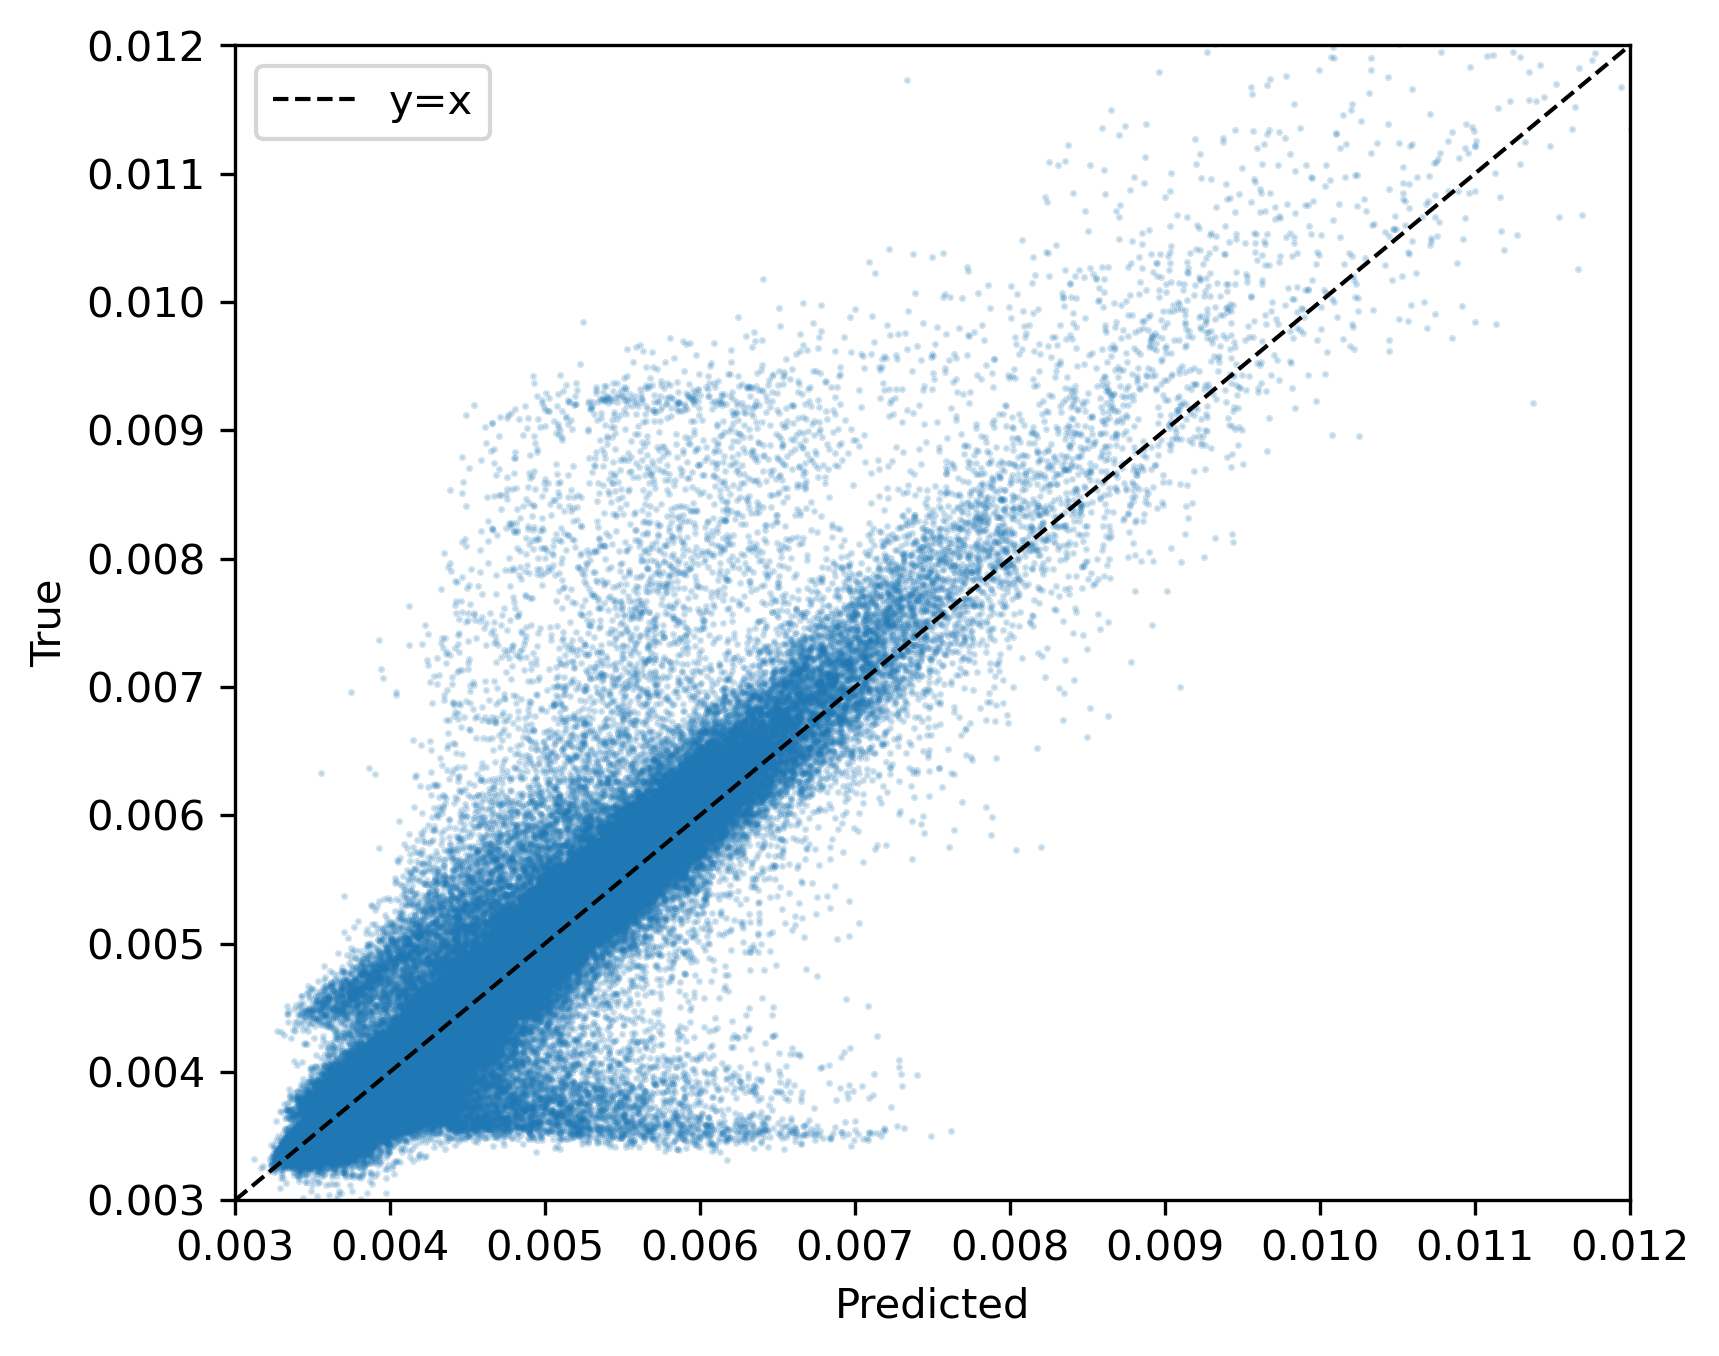

In [24]:
plt.figure(dpi=300, figsize=(6, 5))
plt.scatter(predicted['epz'], data['epz'], s=0.5, alpha=0.2)
plt.plot([0.003, 0.012], [0.003, 0.012], color='black', linestyle='--', linewidth=1, label='y=x')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.xlim(0.003, 0.012)
plt.ylim(0.003, 0.012)
plt.legend()

plt.show()

In [25]:
# data['pz'] = np.sqrt(np.square(data['p'])-np.square(data['pt']))
# data['epz'] = data['ep']*data['p']/data['pz']

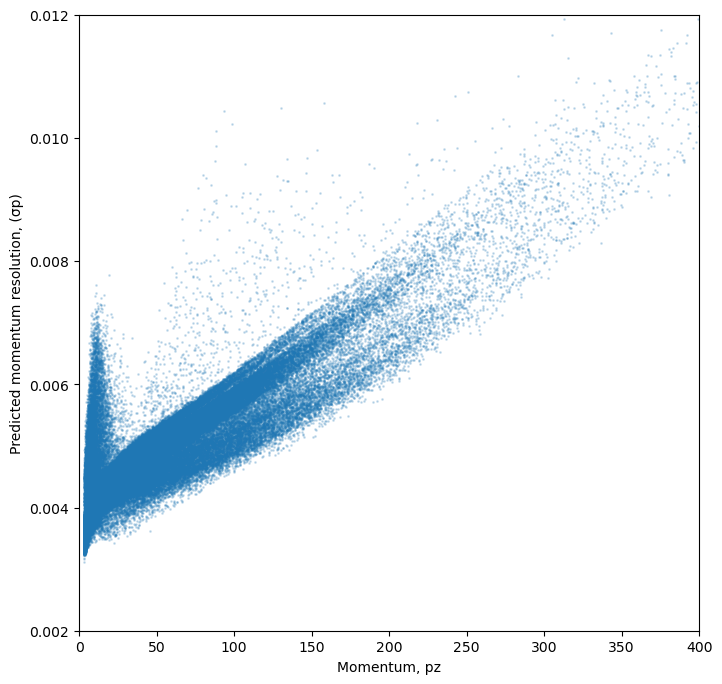

In [26]:
plt.figure(dpi=100, figsize=(8, 8))
plt.scatter(data['pz'], predicted['epz'], s=1, alpha=0.2)
plt.xlabel('Momentum, pz')
plt.ylabel('Predicted momentum resolution, (σp)')
plt.xlim(0, 400)
plt.ylim(0.002, 0.012)
plt.show()